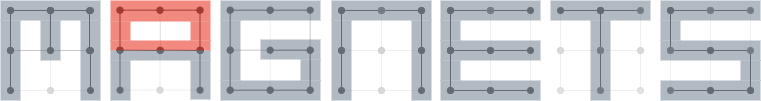

# MAGNets Example

We will demonstrate reducing the hydraulic model of network KY2 <br>

In [ ]:
# here we pip install all the packages we will be using this ipynb file.
!pip install magnets wntr matplotlib networkx 

## Import packages

In [ ]:
# here we import the packages we just installed above.
import magnets as mg
import time
import wntr
import matplotlib.pyplot as plt
import networkx.drawing.nx_pylab as nxp

import warnings
warnings.filterwarnings('ignore')

## Network plotting

In [ ]:
# We will use this function to plot the networks
# Red squares represent reservoirs and blue hexagons represent tanks

def plot_network(wn, title, num):

    G = wn.get_graph()
    G_edge_list = list(G.edges())

    pos_dict = {}
    for node_name, node in wn.nodes():
        pos_dict[node_name] = node.coordinates

    plt.sca(ax[num])
    nxp.draw_networkx_nodes(G, pos_dict, node_size = 5, node_color = 'k', ax = ax[num])
    nxp.draw_networkx_nodes(G, pos_dict, nodelist = wn.tank_name_list, node_size = 30, node_color = 'b', node_shape = 'h', ax = ax[num])
    nxp.draw_networkx_nodes(G, pos_dict, nodelist = wn.reservoir_name_list, node_size = 30, node_color = 'r', node_shape = 's', ax = ax[num])
    nxp.draw_networkx_edges(G, pos_dict, edgelist = G_edge_list, edge_color = 'k', width = 1, arrows = False, ax = ax[num])
    ax[num].set_axis_off
    ax[num].set_title(title)

## Getting started

MAGNets' `reduce_model` function allows the user to reduce the hydraulic model of a water distribution network (WDN) to a hydraulically equivalent model with fewer nodes.

The inputs of the `reduce_model` function include:
1. `inp_file`: the EPANET-compatible .inp file of the water distribution network model.
2. `op_pt`: (optional, default = 0) the operating point, or the reporting time step of the hydraulic simulation at which the non-linear headloss equations are linearized.
3. `nodes_to_keep`: (optional, default = []) a list of nodes the user wishes to retain in the reduced model.
4. `max_nodal_degree`: (optional, default = None) the maximum nodal degree of nodes being removed from the model. The nodal degree of a node is equal to the number of pipes incident to the node.

The outputs of the `reduce_model` function include:
1. water network model object of the reduced network model
2. .inp file of the reduced network written into the folder it is located in.

## Setting a baseline
Let us begin by running a hydraulic simulation (using WNTR) for network KY2 and plotting tank level simulation reuslts.

In [ ]:
# Define .INP file of network model 
inp_file = 'networks/ky2.inp'

# Define water network model
wn = wntr.network.WaterNetworkModel(inp_file) 

# Run a hydaulic simulation using the EPANET engine
sim = wntr.sim.EpanetSimulator(wn)            
results = sim.run_sim()

In [ ]:
# Plot KY2 tank levels 
fig, ax = plt.subplots(1,wn.num_tanks,figsize=(14,4))
for index, tank_name in enumerate(wn.tank_name_list):
    ax[index].plot(results.node['head'].index/3600, results.node['head'].loc[:,tank_name], lw = 2, color = 'r')
    ax[index].set_xlabel('Time [hr]', fontsize = 18)
    ax[index].set_ylabel('{} tank level [m]'.format(tank_name), fontsize = 18)
fig.tight_layout()

## Basic model reduction
In this example, we demonstrate how to reduce a network model without proving any optional input. We plot the original and reduced networks, as well as number of nodes and links, running time, and tank levels.

In [ ]:
# Call model reduction function
t1 = time.time()
mg1 = mg.reduction.reduce_model(inp_file)
t2 = time.time()

# Plot the original network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
wn = wntr.network.WaterNetworkModel(inp_file)
plot_network(wn, 'Full network', 0)

# Plot the reduced network
wn2 = wntr.network.WaterNetworkModel('networks/reduced 0 ky2.inp')
plot_network(wn2, 'Fully reduced network', 1)
plt.setp(ax, ylim=ax[0].get_ylim())
plt.setp(ax, xlim=ax[0].get_xlim())

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn2.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn2.num_pipes, "\033[0;0m")

In [ ]:
# Run a hydaulic simulation for the reduced model 
sim2 = wntr.sim.EpanetSimulator(wn2)            
results2 = sim2.run_sim()

# Plot KY2 tank levels 
fig, ax = plt.subplots(1,3,figsize=(14,4))
for index, tank_name in enumerate(wn.tank_name_list):
    ax[index].plot(results.node['head'].index/3600, results.node['head'].loc[:,tank_name], lw = 2, color = 'r', label = 'Full network')
    ax[index].plot(results2.node['head'].index/3600, results2.node['head'].loc[:,tank_name], lw = 2, color = 'limegreen', linestyle = 'dashdot', label = 'Fully reduced network')
    ax[index].set_xlabel('Time [hr]', fontsize = 18)
    ax[index].set_ylabel('{} tank level [m]'.format(tank_name), fontsize = 18)
ax[0].legend()
fig.tight_layout()

## Provide operating point and a list of nodes to keep
In this example, we demonstrate how to reduce a network model proving an operating point and a list of nodes to keep in the reduced model. We plot the original and reduced networks, as well as number of nodes and links, running time, and tank levels.

In [ ]:
# Specify operating point (optional)
op_pt = 13

# Specify list of nodes to keep (optional)
list_of_nodes_to_keep = ['J-103','J-50']

# Specify maximum nodal degree of nodes being removed from the model (optional)
# max_nodal_degree = 1 indicates removal of only branches and merging of parallel pipes
# max_nodal_degree = 2 indicates removal of branches, merging of parallel pipes, and merging of pipes in series
max_nodal_degree = None

# Call model reduction function
t1 = time.time()
wn3 = mg.reduction.reduce_model(inp_file, op_pt, list_of_nodes_to_keep, max_nodal_degree)
t2 = time.time()

# Plot the original network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_network(wn, 'Full network', 0)

# Plot the reduced network
plot_network(wn3, 'Partially reduced network', 1)
plt.setp(ax, ylim=ax[0].get_ylim())
plt.setp(ax, xlim=ax[0].get_xlim())

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn3.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn3.num_pipes, "\033[0;0m")

In [ ]:
# Run a hydaulic simulation for the reduced model 
sim3 = wntr.sim.EpanetSimulator(wn3)            
results3 = sim3.run_sim()

# Plot KY2 tank levels 
fig, ax = plt.subplots(1,3,figsize=(14,4))
for index, tank_name in enumerate(wn.tank_name_list):
    ax[index].plot(results.node['head'].index/3600, results.node['head'].loc[:,tank_name], lw = 2, color = 'r', label = 'Full network')
    ax[index].plot(results3.node['head'].index/3600, results3.node['head'].loc[:,tank_name], lw = 2, color = 'limegreen', linestyle = 'dashdot', label = 'Partially reduced network')
    ax[index].set_xlabel('Time [hr]', fontsize = 18)
    ax[index].set_ylabel('{} tank level [m]'.format(tank_name), fontsize = 18)
ax[0].legend()
fig.tight_layout()

### We can see that the choice of operating point can affect how well the reduced model matches the full model.

## Remove all branches
In this example, we demonstrate how to reduce a network model by removing all nodes with node degree equal to 1 (i.e., branches). We plot the original and reduced networks, as well as number of nodes and links, running time, and tank levels.

In [ ]:
#Specify maximum nodal degree in reduced model (optional)
max_nodal_degree = 1

# Call model reduction function
t1 = time.time()
wn4 = mg.reduction.reduce_model(inp_file, None, None, max_nodal_degree)
t2 = time.time()

# Plot the original network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_network(wn, 'Full network', 0)

# Plot the reduced network
plot_network(wn4, 'Removing all branches', 1)
plt.setp(ax, ylim=ax[0].get_ylim())
plt.setp(ax, xlim=ax[0].get_xlim())

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn4.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn4.num_pipes, "\033[0;0m")

In [ ]:
# Run a hydaulic simulation for the reduced model 
sim4 = wntr.sim.EpanetSimulator(wn4)            
results4 = sim4.run_sim()

# Plot KY2 tank levels 
fig, ax = plt.subplots(1,3,figsize=(14,4))
for index, tank_name in enumerate(wn.tank_name_list):
    ax[index].plot(results.node['head'].index/3600, results.node['head'].loc[:,tank_name], lw = 2, color = 'r', label = 'Full network')
    ax[index].plot(results4.node['head'].index/3600, results4.node['head'].loc[:,tank_name], lw = 2, color = 'limegreen', linestyle = 'dashdot', label = 'Removing all branches')
    ax[index].set_xlabel('Time [hr]', fontsize = 18)
    ax[index].set_ylabel('{} tank level [m]'.format(tank_name), fontsize = 18)
ax[0].legend()
fig.tight_layout()

## Remove all branches and pipes in series
In this example, we demonstrate how to reduce a network model by removing all nodes with node degree equal or less than 2 (i.e., all branches and pipes in series). We plot the original and reduced networks, as well as number of nodes and links, running time, and tank levels.

In [ ]:
# Specify maximum nodal degree in reduced model
max_nodal_degree = 2

# Call model reduction function
t1 = time.time()
wn5 = mg.reduction.reduce_model(inp_file, None, None, max_nodal_degree)
t2 = time.time()

# Plot the original network
fig, ax = plt.subplots(1, 2, figsize=(12,5))
plot_network(wn, 'Full network', 0)
plt.setp(ax, ylim=ax[0].get_ylim())
plt.setp(ax, xlim=ax[0].get_xlim())

# Plot the reduced network
plot_network(wn5, 'Removing all branches and pipes in series', 1)

# Display reduction time and number of elements
print('Total reduction time:', str(round(t2-t1, 2)), 's')
print('Number of junctions in the original network:', "\033[1m", wn.num_junctions, "\033[0;0m", 'vs. number of junctions in the reduced network:',"\033[1m", wn5.num_junctions, "\033[0;0m")
print('Number of pipes in the original network:', "\033[1m",wn.num_pipes,"\033[0;0m", 'vs. number of pipes in the reduced network:',"\033[1m", wn5.num_pipes, "\033[0;0m")

In [ ]:
# Run a hydaulic simulation for the reduced model 
sim5 = wntr.sim.EpanetSimulator(wn5)            
results5 = sim5.run_sim()

# Plot KY2 tank levels 
fig, ax = plt.subplots(1,3,figsize=(14,4))
for index, tank_name in enumerate(wn.tank_name_list):
    ax[index].plot(results.node['head'].index/3600, results.node['head'].loc[:,tank_name], lw = 2, color = 'r', label = 'Full network')
    ax[index].plot(results5.node['head'].index/3600, results5.node['head'].loc[:,tank_name], lw = 2, color = 'limegreen', linestyle = 'dashdot', label = 'Removing all branches and pipes in series')
    ax[index].set_xlabel('Time [hr]', fontsize = 18)
    ax[index].set_ylabel('{} tank level [m]'.format(tank_name), fontsize = 18)
ax[0].legend()
fig.tight_layout()